# Predicting Heart Disease Based on Relevant Body Data in Switzerland

### Group member:
Anyna Wang 53713814

Lindsay Watson 62396171

Yiman Ma 22858963

## Introduction:

##### background information
Many people do not know they have heart disease until it happens; however, with modern technology, we can predict how likely people are to have heart disease based on information like age, blood pressure and heart rate. Thus, patients can prevent and monitor their heart health in advance. “It has been shown that increase in heart rate by 10 beats per minute was associated with an increase in the risk of cardiac death, and this increase in the risk is similar with an increase in systolic blood pressure by 10 mm Hg” (Perret-Guillaume et al., 2009). 

##### state the question
Therefore, our question is, are age, maximum heart rate, and blood pressure strongly associated with the diagnosis of heart disease? If so, can we accurately predict the diagnosis of heart disease with these three predictors? KNN binary classification algorithm will be used to predict the diagnosis. We will also estimate the accuracy of our model to predict the disease. 


##### identify and describe the dataset
The data set is from the UCI machine learning repository. It consists of 303 instances from patients and each row presents a piece of information about patients.

## Method & Results

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(tidymodels)
library(digest)
library(repr)
library(ggplot2)
library(cowplot)
library(testthat)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### 1. loads data from the original source on the web 

We have imported and organized switzerland heart disease data, established variable names, changed variable types, and finally removed unrealistic and useless information.

In [2]:
# The url is a copy link of heart disease data set from UCI Machine Learning Repository website.
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"

# Naming each columns based on the information from UCI Machine Learning Repository.
names <- c("age",
           "sex",
           "chest_pain_type",
           "resting_blood_pressure",
           "serum_cholestoral (mg/dl)",
           "fasting_blood_sugar",
           "resting_electrocardiographic_results",
           "maximum_heart_rate",
           "exercise_induced_angina",
           "ST_depression",
           "slope_of_the_peak_exercise_ST_segment",
           "number_of_major_vessels",
           "thal",
           "diagnosis_of_heart_disease")

# Loading processed switzerland heart disease data set
original_switzerland_data <- read_delim(url, delim = ",", col_names = names) |>

                             # making categorie variables as a factor
                             mutate(across(sex : chest_pain_type, as_factor)) |>
                             mutate(across(fasting_blood_sugar : resting_electrocardiographic_results, as_factor)) |>
                             mutate(exercise_induced_angina = as_factor(exercise_induced_angina)) |>
                             mutate(slope_of_the_peak_exercise_ST_segment = as_factor(slope_of_the_peak_exercise_ST_segment)) |>
                             mutate(thal = as_factor(thal)) |>

                             # making age as a integer, because it can't have negative and decimals.
                             mutate(age = as.integer(age)) |>
                    
                             # making number of major vessels as integer, because it has a range with 0-3.
                             mutate(number_of_major_vessels = as.integer(number_of_major_vessels)) |>

                             # making quantitative variables as a double
                             mutate(resting_blood_pressure = as.double(resting_blood_pressure)) |>
                             mutate(maximum_heart_rate = as.double(maximum_heart_rate)) |>
                             mutate(ST_depression = as.double(ST_depression)) 

# If diagnosis of heart disease is 0 
original_switzerland_data$diagnosis_of_heart_disease <- ifelse(original_switzerland_data$diagnosis_of_heart_disease == 0, "false", "true")

# It is impossible to have 0 blood pressure, delate the impossible data. 
# Making diagnosis of heart disease as factor
original_switzerland_data <- original_switzerland_data |>
                             filter(resting_blood_pressure != 0) |>
                             mutate(diagnosis_of_heart_disease = as_factor(diagnosis_of_heart_disease))

# Data can not be "?", replace "?" to NA
original_switzerland_data <- replace(original_switzerland_data , original_switzerland_data == "?", NA)

# First 6 row of the data set
head(original_switzerland_data)

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): resting_blood_pressure, fasting_blood_sugar, resting_electrocardiog...
dbl (5): age, sex, chest_pain_type, serum_cholestoral (mg/dl), diagnosis_of_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,chest_pain_type,resting_blood_pressure,serum_cholestoral (mg/dl),fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate,exercise_induced_angina,ST_depression,slope_of_the_peak_exercise_ST_segment,number_of_major_vessels,thal,diagnosis_of_heart_disease
<int>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>
32,1,1,95,0,NA,0,127,0,0.7,1,NA,NA,true
34,1,4,115,0,NA,NA,154,0,0.2,1,NA,NA,true
36,1,4,110,0,NA,0,125,1,1.0,2,NA,6,true
38,0,4,105,0,NA,0,166,0,2.8,1,NA,NA,true
38,0,4,110,0,0,0,156,0,0.0,2,NA,3,true
38,1,3,100,0,NA,0,179,0,-1.1,1,NA,NA,false


#### 2. wrangles and cleans the data from original

We selected three variables, resting blood pressure, maximum heart rate, and age, from the 14 variables in the database to predict the diagnosis of heart disease. We'll use these three variables because research has linked elevated blood pressure and heart rate to heart disease.

In [3]:
# wrangle data set, select the columns that the research will use.
switzerland_heart_disease_data <- original_switzerland_data |> 
             select(age, resting_blood_pressure, maximum_heart_rate, diagnosis_of_heart_disease)

head(switzerland_heart_disease_data)

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
32,95,127,true
34,115,154,true
36,110,125,true
38,105,166,true
38,110,156,true
38,100,179,false


#### 3. performs a summary

We seeded the dataset for random splits to ensure reproducible results. Then, we split the data into training and testing datasets. The training set is used to build the classifier, and the test set is used to evaluate the accuracy of the classifier's predictions. We hope to use three more quantitative variables (blood pressure, maximum heart rate, and age) to predict whether there is a categorical variable of heart disease.

In [4]:
# Making the training data
set.seed(2700)
heart_disease_split <- initial_split(switzerland_heart_disease_data, prop = 0.75, strata = diagnosis_of_heart_disease)
heart_disease_training_data <- training(heart_disease_split)
heart_disease_testing_data <- testing(heart_disease_split)
heart_disease_training_data
heart_disease_testing_data

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
32,95,127,true
36,110,125,true
38,105,166,true
⋮,⋮,⋮,⋮
70,140,157,true
72,160,114,false
73,160,121,true


age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<dbl>,<dbl>,<fct>
34,115,154,true
38,150,120,true
42,145,99,true
⋮,⋮,⋮,⋮
65,160,122,true
66,150,108,true
74,145,123,true


Explore the training heart disease dataset. The summary contains the number of each category (with or without heart disease) in the test set, and the average of the three quantitative variables.

In [5]:
# Counting rows that have missing data
data_missing_num <- heart_disease_training_data|>
                    map_df(is.na)|>
                    map_df(sum)
data_missing_num

# Counting rows that have data, calculating the mean of age, mean of blood pressure and mean of maximum heart rate
heart_disease_summarize <- heart_disease_training_data|>
                           group_by(diagnosis_of_heart_disease) |>
                           summarize(n_age = sum(!is.na(age)),
                                     n_resting_blood_pressure = sum(!is.na(resting_blood_pressure)),
                                     n_maximum_heart_rate = sum(!is.na(maximum_heart_rate)),
                                     n_diagnosis_of_heart_disease = sum(!is.na(diagnosis_of_heart_disease)),
                                     mean_age = mean(age, na.rm=TRUE),
                                     mean_blood_pressure = mean(resting_blood_pressure, na.rm=TRUE),
                                     mean_heart_rate = mean(maximum_heart_rate, na.rm=TRUE))
heart_disease_summarize

age,resting_blood_pressure,maximum_heart_rate,diagnosis_of_heart_disease
<int>,<int>,<int>,<int>
0,0,0,0


diagnosis_of_heart_disease,n_age,n_resting_blood_pressure,n_maximum_heart_rate,n_diagnosis_of_heart_disease,mean_age,mean_blood_pressure,mean_heart_rate
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
true,83,83,83,83,55.32530,127.6506,122.8916
false,7,7,7,7,54.57143,122.1429,134.7143


#### 4. creates a visualization

We created two scatterplots to visualize resting blood pressure and maximum heart rate as a function of age. And the existence of heart disease and the absence of heart disease are used as two classifications, and the points in the picture are divided into two different colors. We will find the relationship between these two variables, first to see if they are strongly correlated, and then to see if this relationship can be used to predict a heart disease diagnosis.

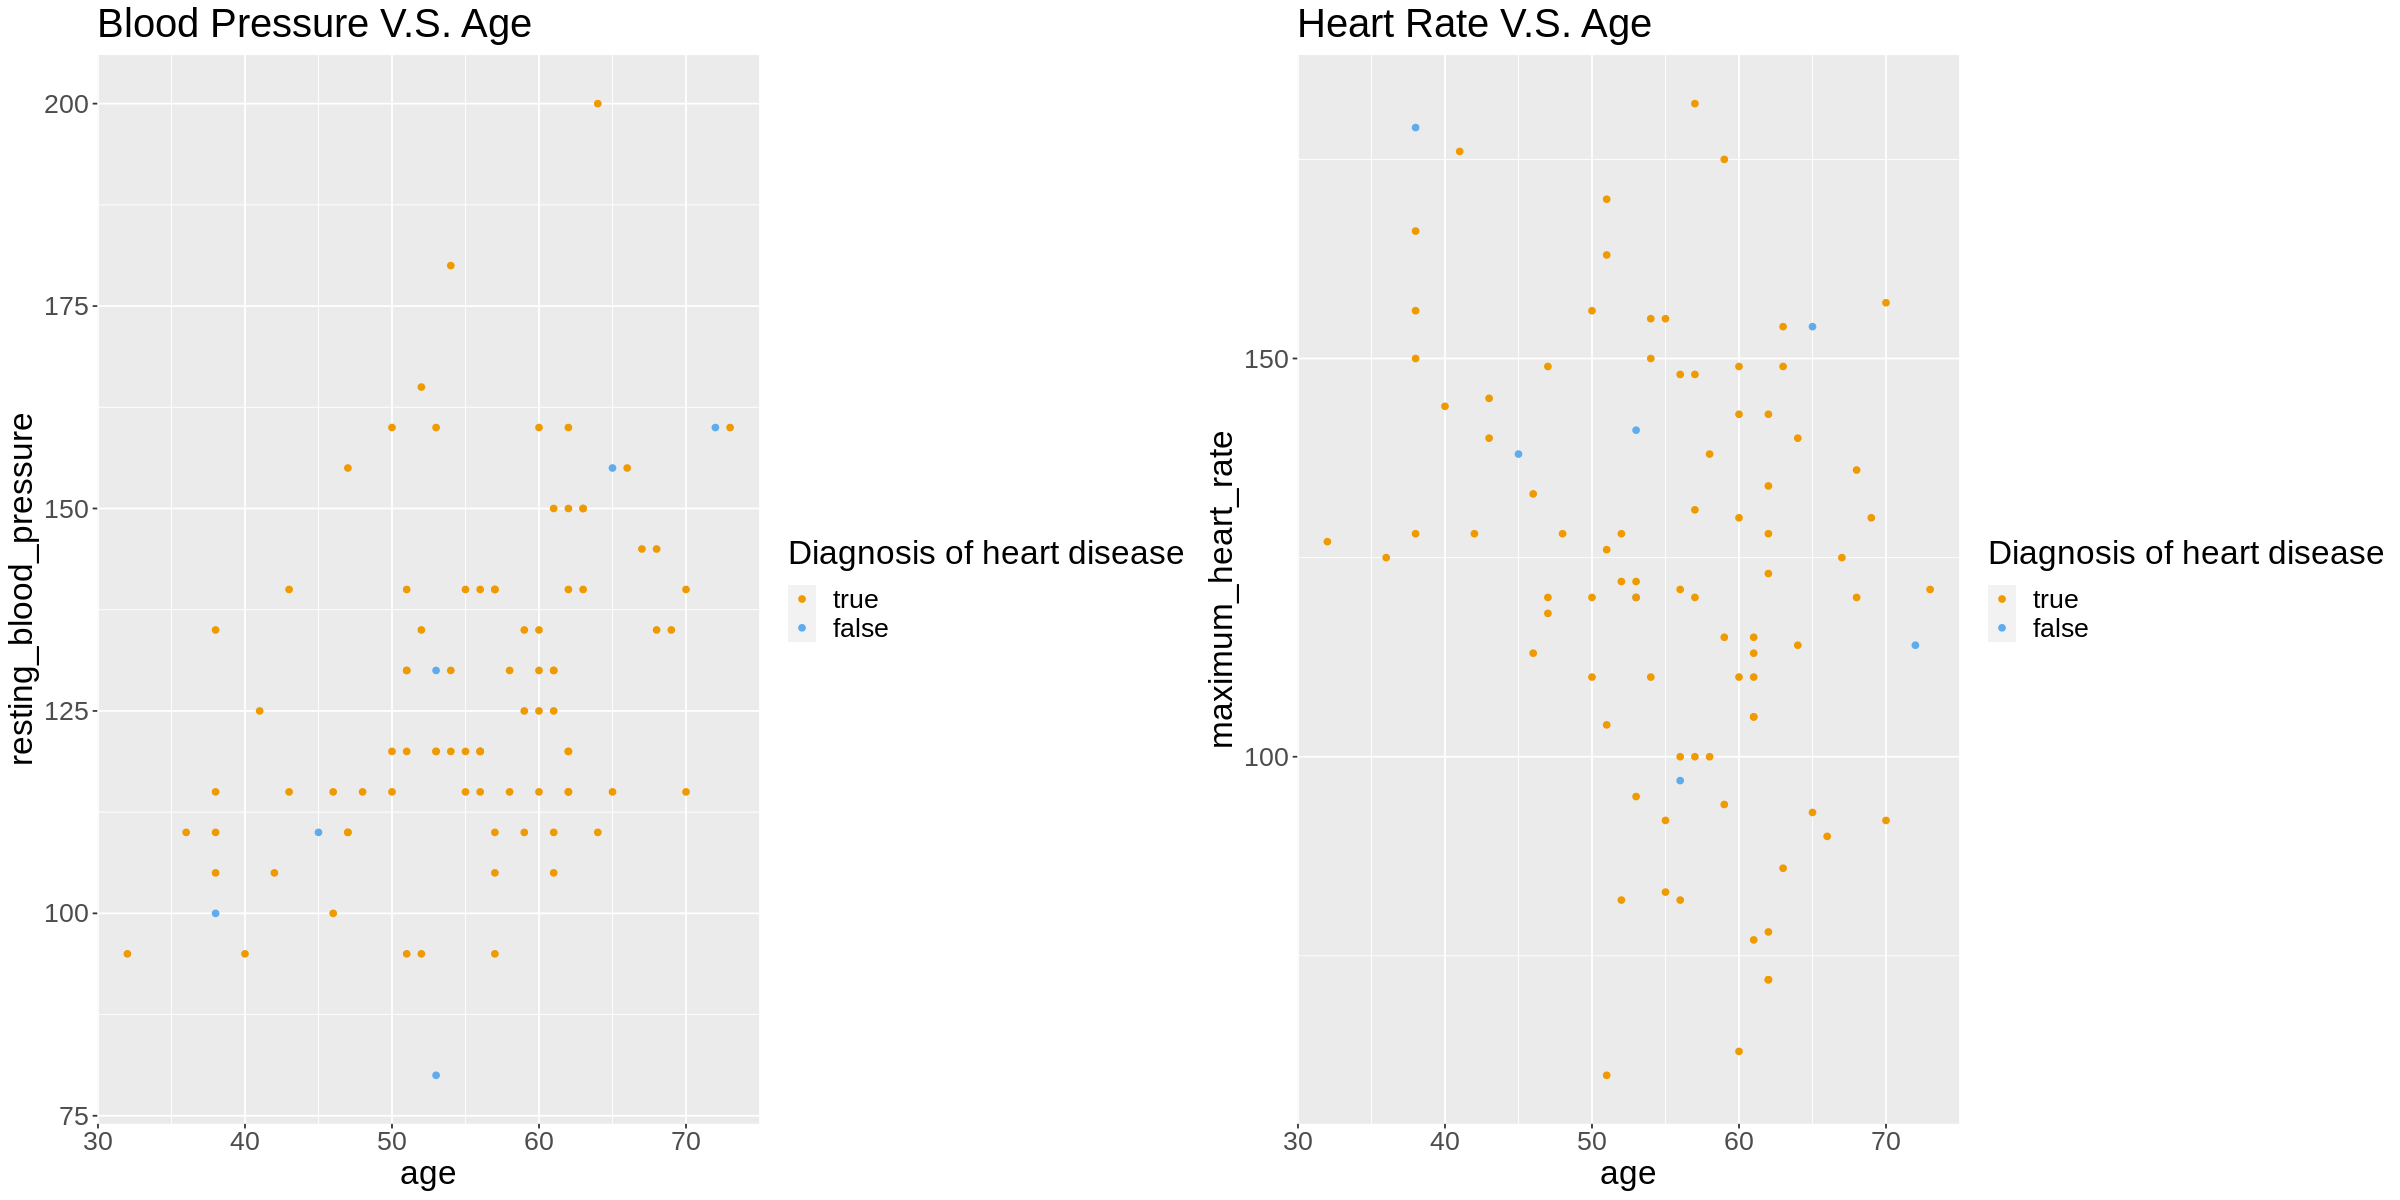

In [7]:
# Create a scatterplot to visualize the relationship between two quantitative variables, categorized by the presence or 
# absence of heart disease
# The following creates 2 scatterplots: Blood Pressure V.S. Age, Heart Rate V.S. Age
Age_BP <- heart_disease_training_data |>
    ggplot(aes(x = age, y = resting_blood_pressure, color = diagnosis_of_heart_disease)) +
    geom_point(alpha = 5) +
    labs(color = "Diagnosis of heart disease") +
    ggtitle("Blood Pressure V.S. Age")+
    scale_color_manual(labels = c("true", "false"), 
                       values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 20))

Age_HR <- heart_disease_training_data |>
    ggplot(aes(x = age, y = maximum_heart_rate, color = diagnosis_of_heart_disease)) +
    geom_point(alpha = 5) +
    labs(color = "Diagnosis of heart disease") +
    ggtitle("Heart Rate V.S. Age")+
    scale_color_manual(labels = c("true", "false"), 
                       values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 20))

#plot two graphs together
plot_grid(Age_BP, Age_HR)
options(repr.plot.width = 20 ,repr.plot.height = 10)

In order to study whether age, maximum blood pressure and heart rate are related to the presence of heart disease, we also draw proportional bar graphs for these three variables to more intuitively observe their relationship with heart disease.

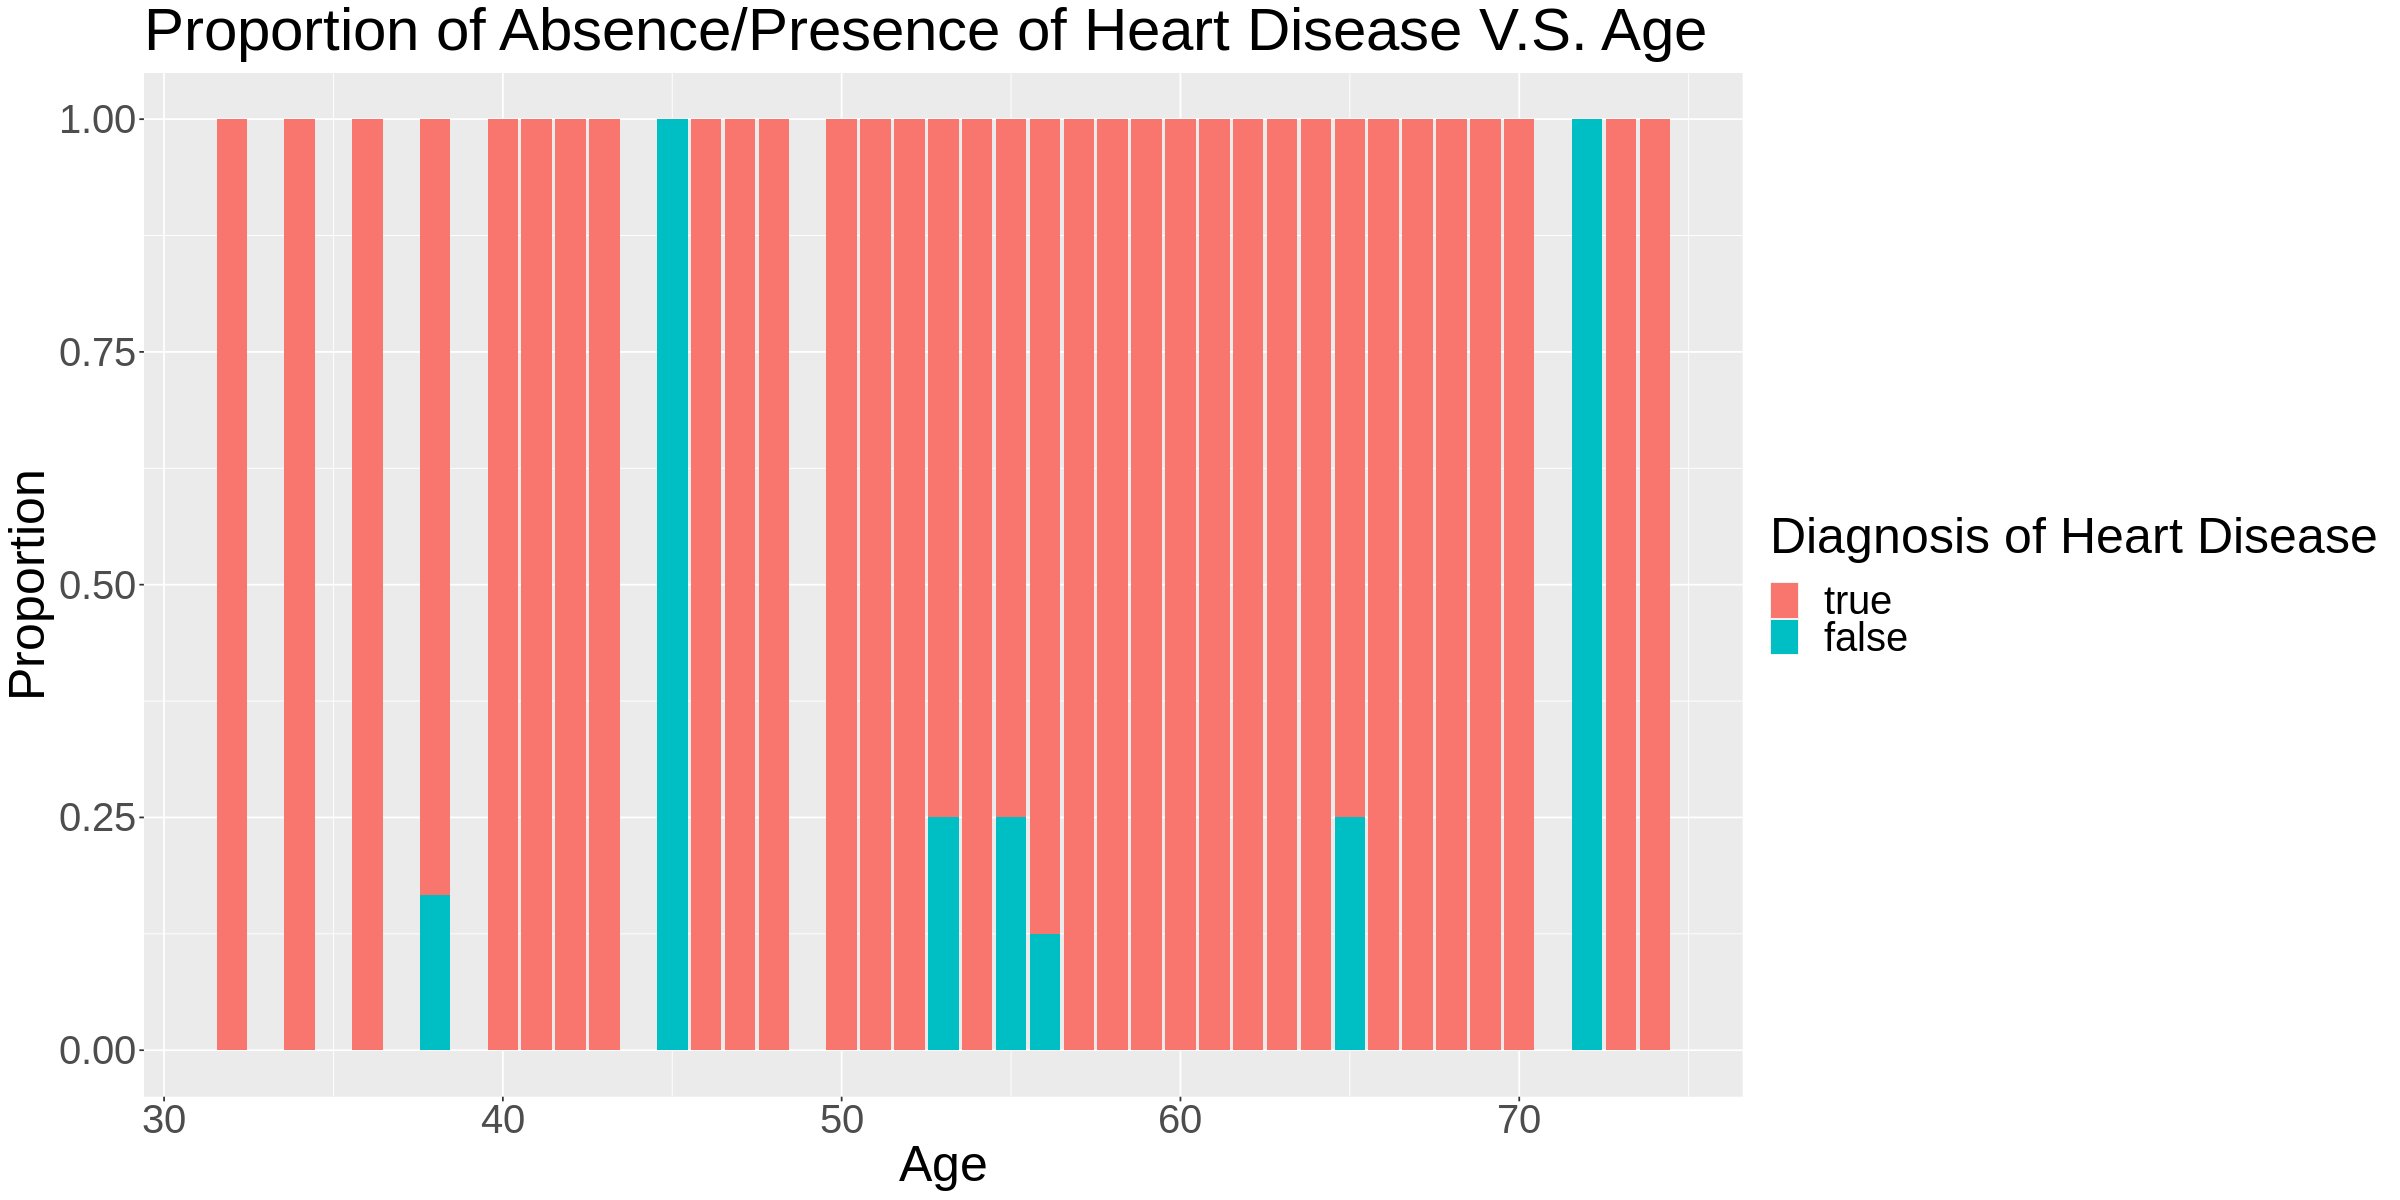

In [8]:
age_graph <- ggplot(data = switzerland_heart_disease_data, aes(x = age, fill = diagnosis_of_heart_disease)) + 
            geom_bar(position = "fill") +
            labs(x = "Age",y = "Proportion", fill = "Diagnosis of Heart Disease") +
             ggtitle("Proportion of Absence/Presence of Heart Disease V.S. Age") +
            theme(text = element_text(size = 30))
age_graph

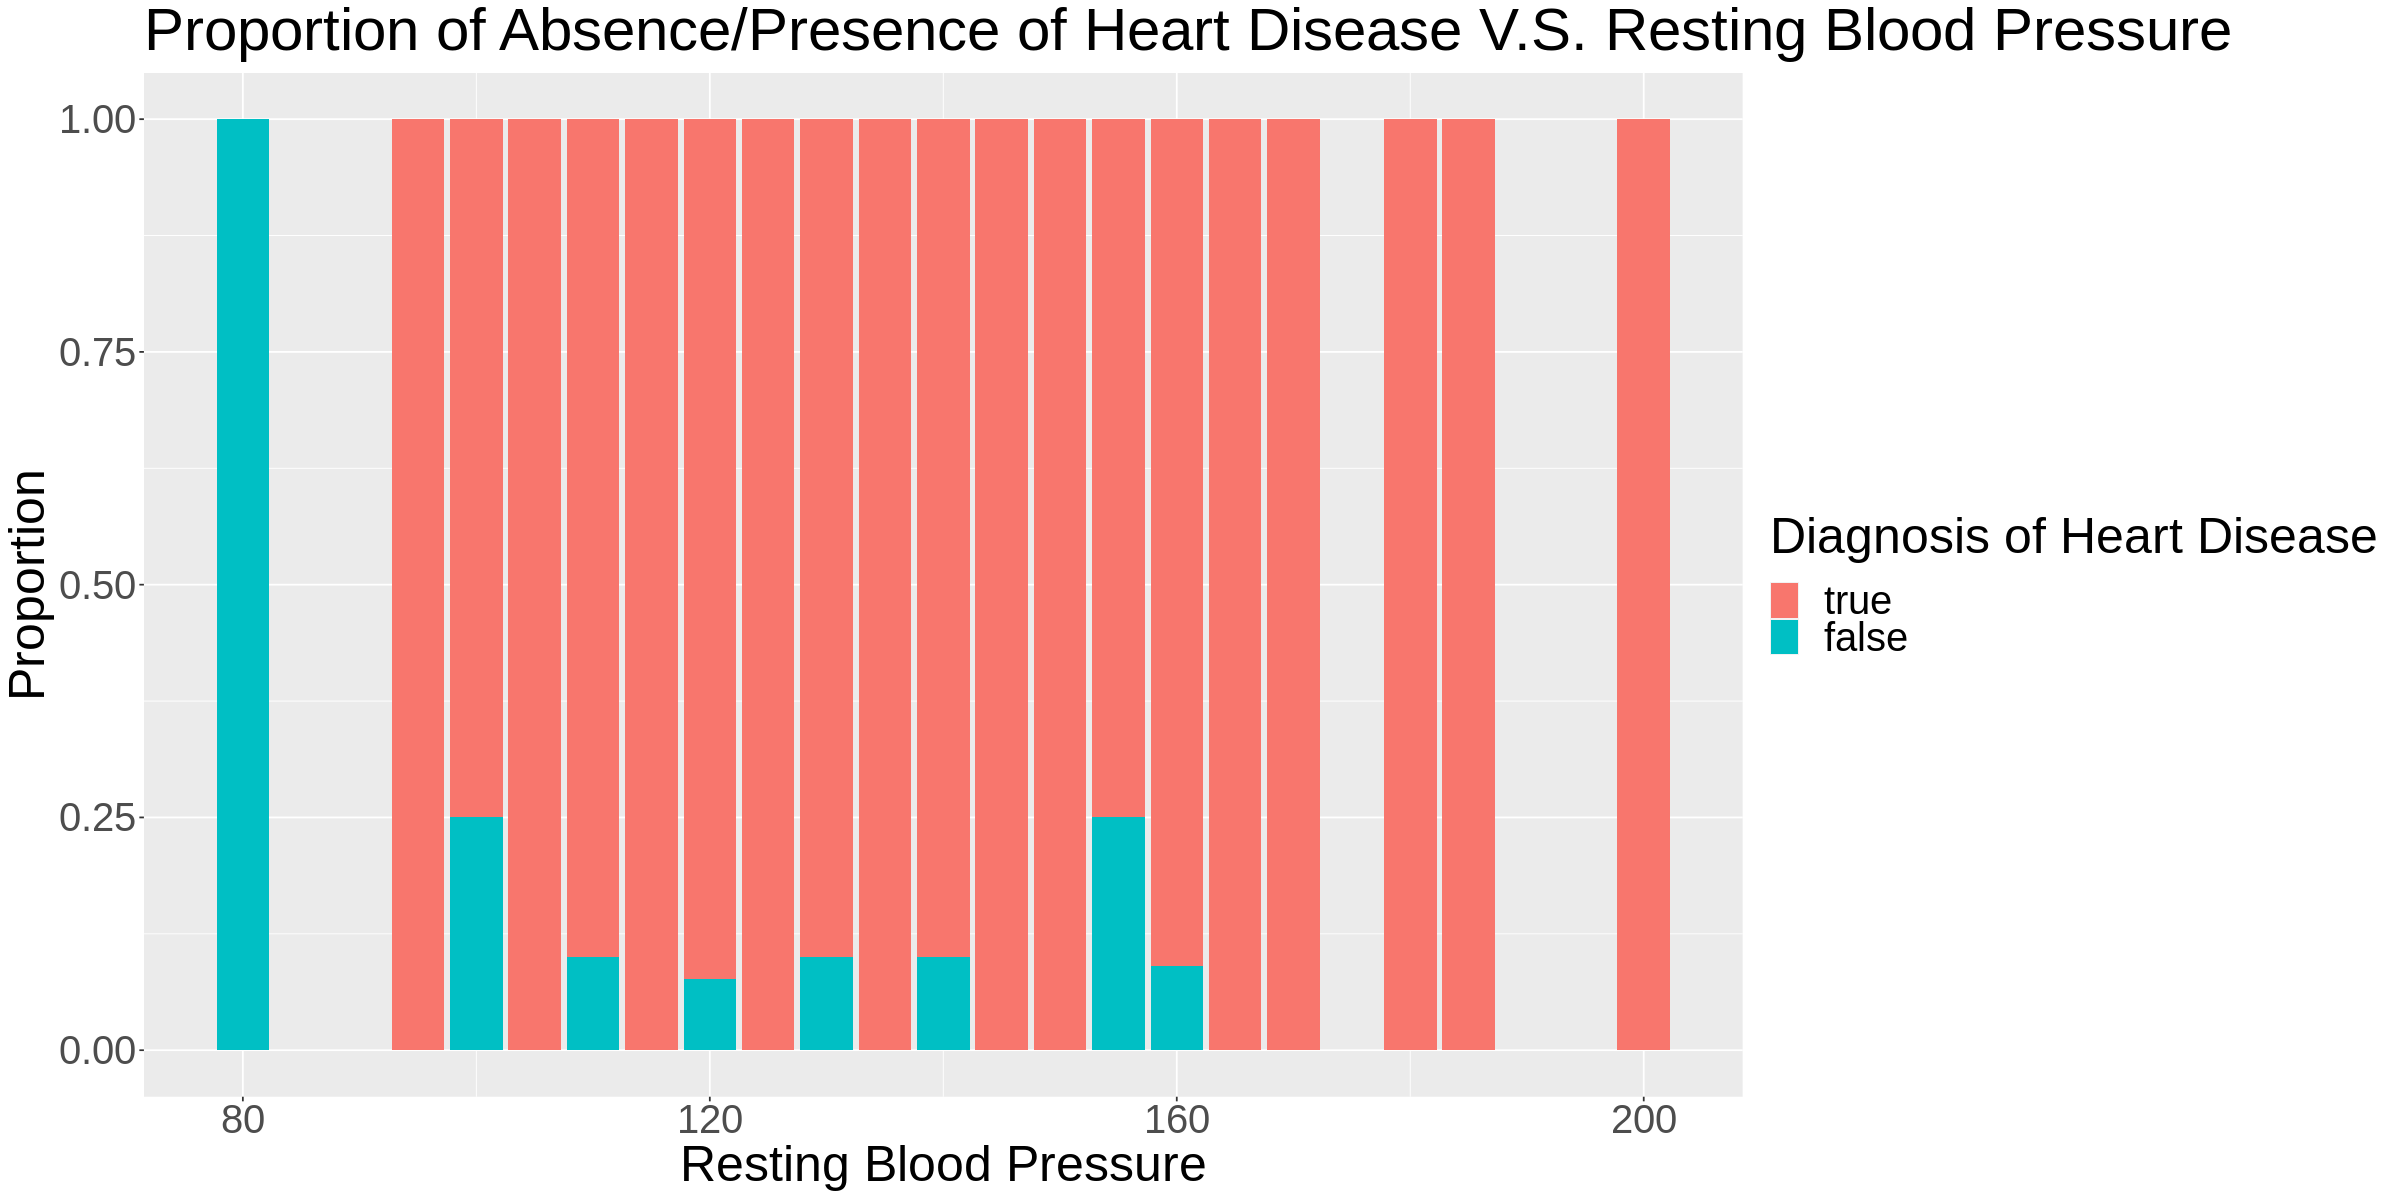

In [9]:
age_graph <- ggplot(data = switzerland_heart_disease_data, aes(x = resting_blood_pressure, fill = diagnosis_of_heart_disease)) + 
            geom_bar(position = "fill") +
            labs(x = "Resting Blood Pressure",y = "Proportion", fill = "Diagnosis of Heart Disease") +
             ggtitle("Proportion of Absence/Presence of Heart Disease V.S. Resting Blood Pressure") +
            theme(text = element_text(size = 30))
age_graph

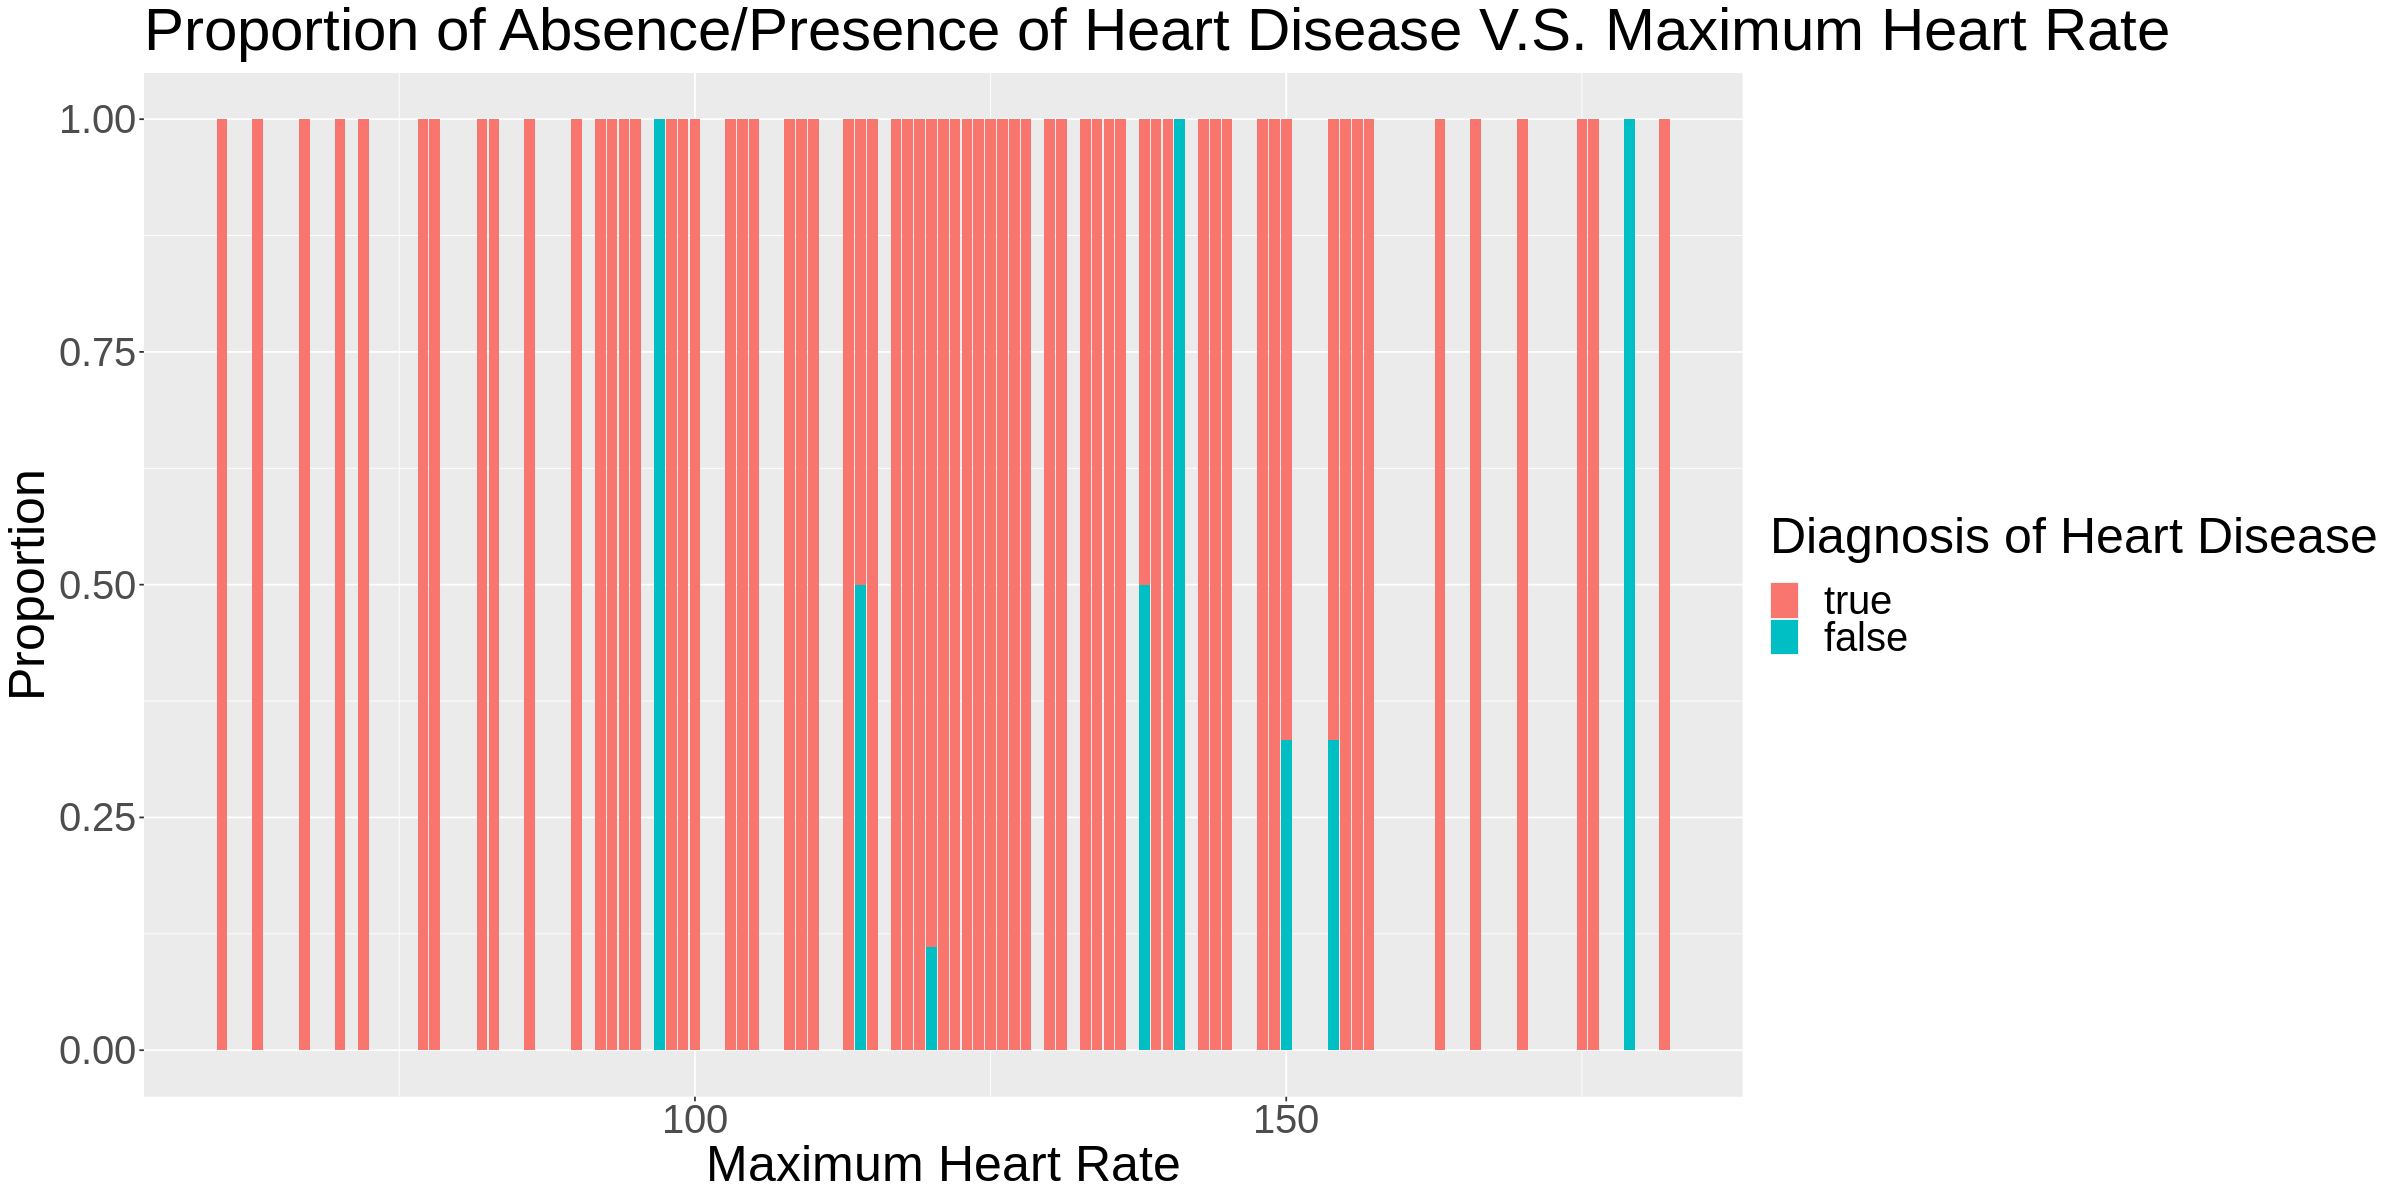

In [10]:
age_graph <- ggplot(data = switzerland_heart_disease_data, aes(x = maximum_heart_rate, fill = diagnosis_of_heart_disease)) + 
            geom_bar(position = "fill") +
            labs(x = "Maximum Heart Rate",y = "Proportion", fill = "Diagnosis of Heart Disease") +
             ggtitle("Proportion of Absence/Presence of Heart Disease V.S. Maximum Heart Rate") +
            theme(text = element_text(size = 30))
age_graph

#### 5. performs the data analysis

Since the predictor variable is a categorical variable, K-nearest neighbors classification is performed on the data. We find the appropriate K value based on the training set. First create the standardized recipe and fit the knn model. The training set is then folded, and the more folds, the more accurate the data. Choose a sequence of k values to try the model on, and get the accuracy for each k value. Finally, draw the relationship between the accuracy rate and K to determine what the K-nearest neighbor should be.

! Fold3: internal: No control observations were detected in `truth` with control level 'fal...



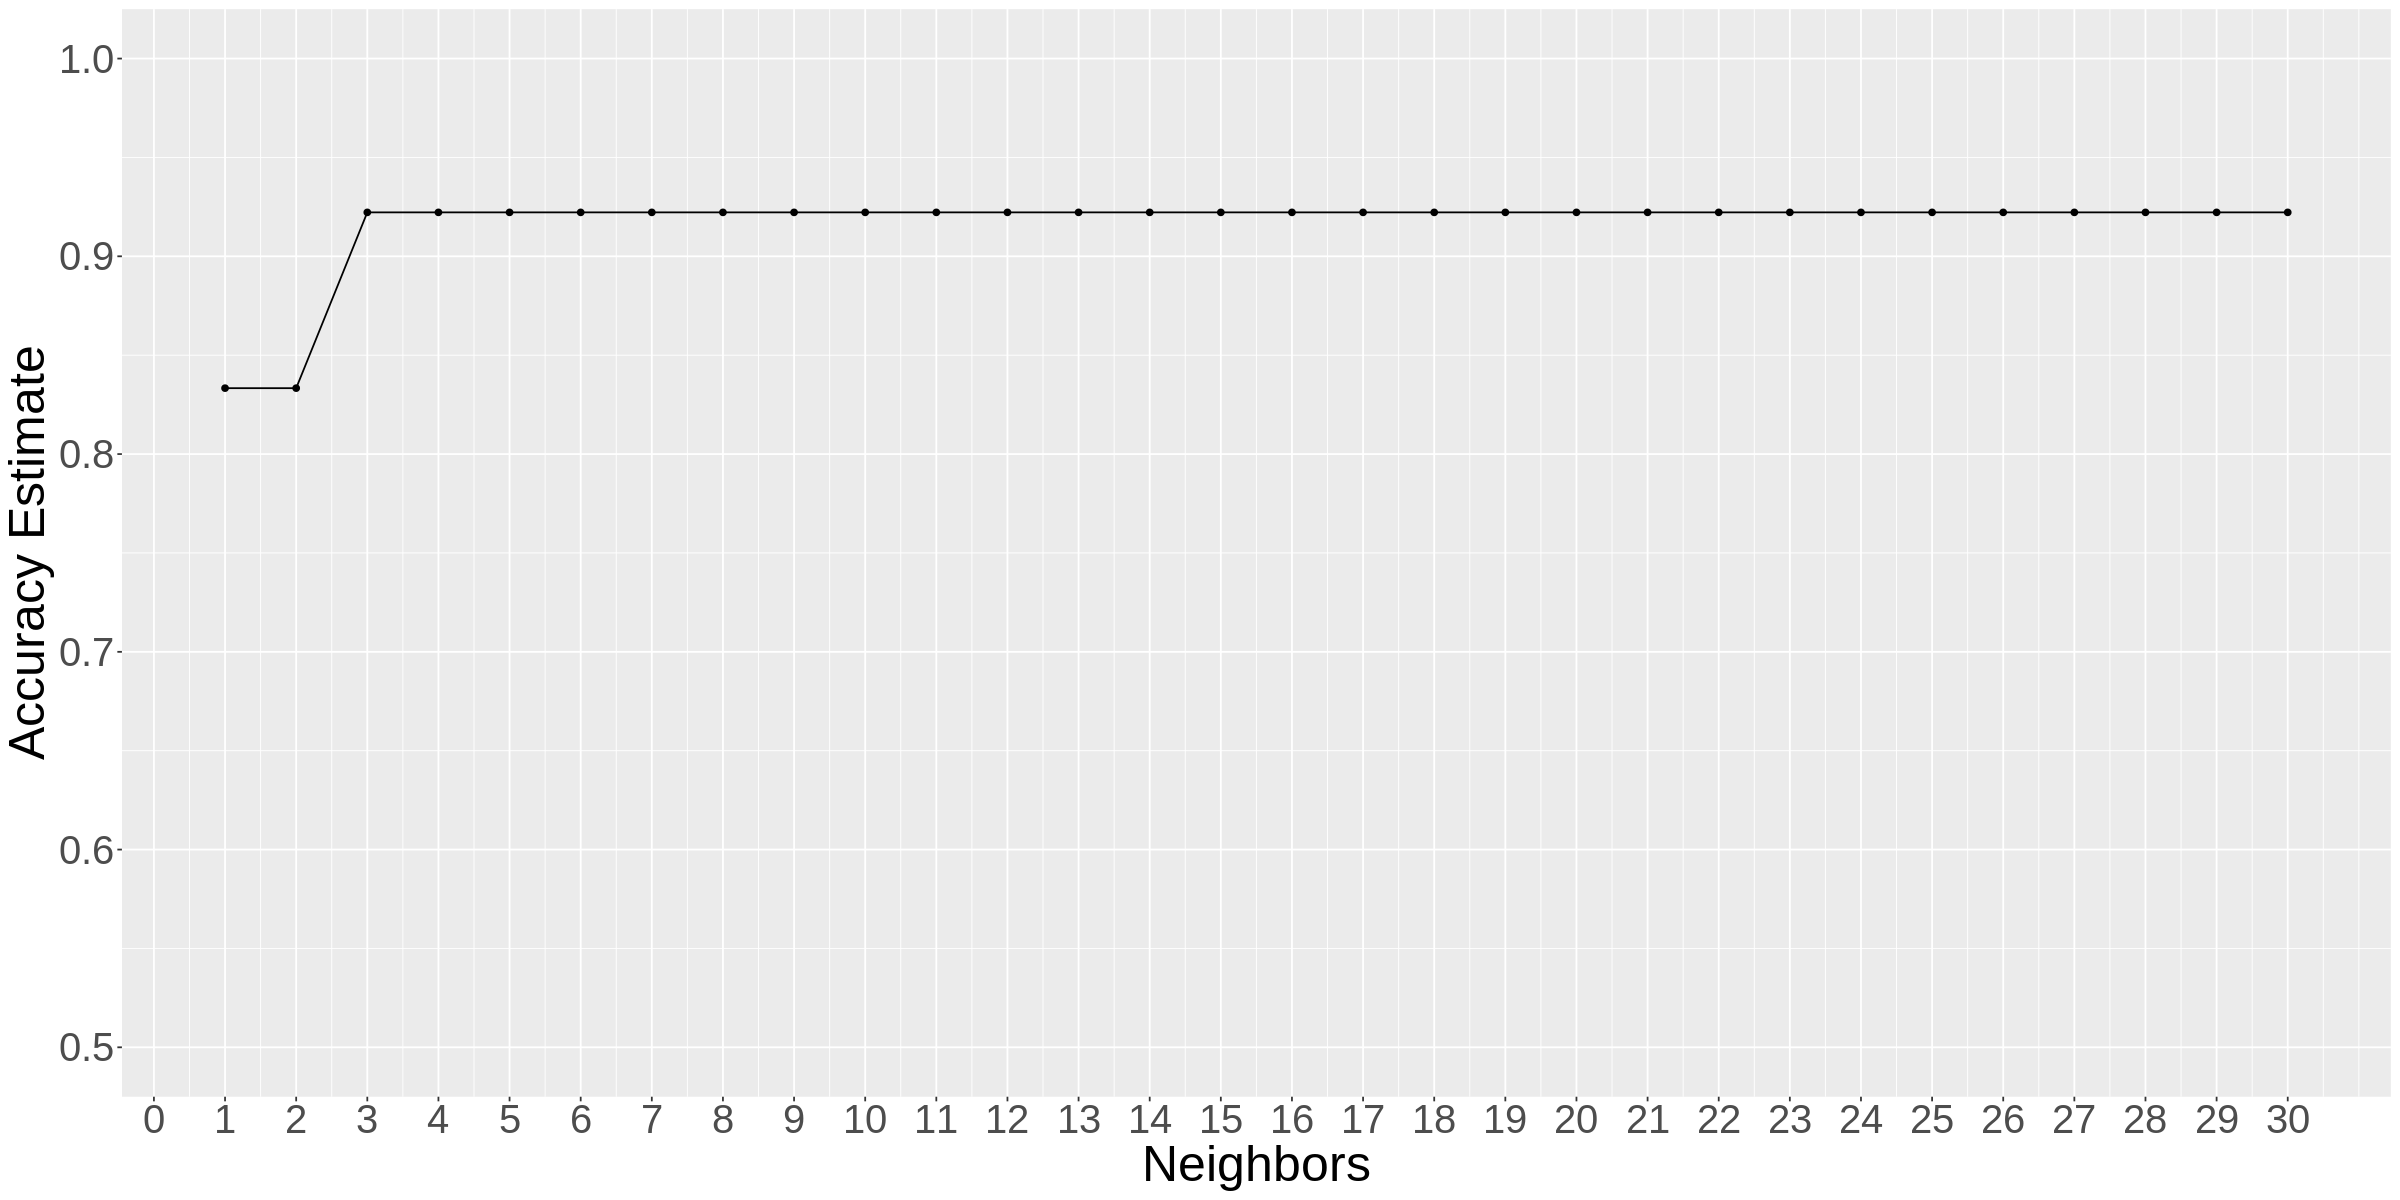

In [57]:
set.seed(2700)
heart_disease_recipe <- recipe(diagnosis_of_heart_disease ~ age + resting_blood_pressure + maximum_heart_rate, data = heart_disease_training_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_disease_vfold <- vfold_cv(heart_disease_training_data, v = 5, strata = diagnosis_of_heart_disease)

k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
    add_recipe(heart_disease_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = heart_disease_vfold, grid = k_vals) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 30)) +
    scale_x_continuous(breaks = seq(0, 30, by = 1)) +  
    scale_y_continuous(limits = c(0.5, 1.0)) 

accuracy_vs_k


Sort the accuracy of each value of k from high to low. We choose 3 as K-neighbor.

In [59]:
max_accuracies <- accuracies|>
    arrange(desc(mean))
max_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.9222222,5,0.02222222,Preprocessor1_Model03
4,accuracy,binary,0.9222222,5,0.02222222,Preprocessor1_Model04
5,accuracy,binary,0.9222222,5,0.02222222,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
30,accuracy,binary,0.9222222,5,0.02222222,Preprocessor1_Model30
1,accuracy,binary,0.8333333,5,0.03928371,Preprocessor1_Model01
2,accuracy,binary,0.8333333,5,0.03928371,Preprocessor1_Model02


Use the classifier to predict heart disease on the test set, using k=3.

In [60]:
set.seed(2700)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_disease_training_data)

heart_test_predictions <- predict(knn_fit, heart_disease_testing_data) |>
  bind_cols(heart_disease_testing_data)

accuracy <- heart_test_predictions |>
  metrics(truth = diagnosis_of_heart_disease, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()
accuracy

confusion <- heart_test_predictions |>
  conf_mat(truth = diagnosis_of_heart_disease, estimate = .pred_class)
confusion


[1] 0.9677419

          Truth
Prediction true false
     true    30     1
     false    0     0


We will use the three variables resting blood pressure, maximum heart rate, and age to predict the diagnosis of heart disease. We will use these three variables because research has shown an increase in blood pressure and heart rate are associated with heart disease. We also chose to use age as a predictor because we wanted to see if there was an association with age and the two other variables that are associated with heart disease. The way we will conduct our data analysis is by first reading the data and then wrangling the data to only contain the four columns we need. We then split the data into a training and testing data set. Next, we created a table with a couple summary statistics such as calculating the mean for our three predictors. Lastly, we created two scatterplots to visualize the relationship between age and blood pressure and age and heart rate. We are going to find the relationship between each of those two variables to see if first they are strongly associated, and then second if this relationship can be used to predict the diagnosis of heart disease. 

## Discussion:
#### expectation for findings:
Through this kind of data analysis, we hope to find the correlation between whether a person has heart disease and variables such as heart rate, blood pressure and age. For example, we predict blood pressure and age based on the two scatterplots we have so far, and heart rate and age may be able to predict a diagnosis of heart disease because the relationship between them is weak.

#### impact:
These findings are important because people need to know their blood pressure and heart rate as they age, because the possible values of these variables may indicate to them that they have a high likelihood of developing heart disease.

#### future questions:
This may lead to future questions about medical diagnosis through data, such as which variable most reliably predicts a diagnosis of heart disease, resting blood pressure, maximum heart rate or age? Or, how do these factors vary depending on your gender?


## References:

Masoli, J. A., Mensah, E., & Rajkumar, C. (2022). Age and ageing cardiovascular collection: Blood pressure, coronary heart disease        and heart failure. Age and Ageing, 51(8). https://doi.org/10.1093/ageing/afac179

Salmoirago-Blotcher, E., Hovey, K. M., Andrews, C. A., Allison, M., Brunner, R. L., Denburg, N. L., Eaton, C., Garcia, L., Sealy-          Jefferson, S. M., Zaslavsky, O., Kang, J., López, L., Post, S. G., Tindle, H., & Wassertheil-Smoller, S. (2019).                    Psychological traits, heart rate variability, and risk of coronary heart disease in healthy aging women—the Women's Health          initiative. Psychosomatic Medicine, 81(3), 256–264. https://doi.org/10.1097/psy.0000000000000672

Wilson, P. W. F. (1997). An epidemiologic perspective of systemic hypertension, ischemic heart disease, and heart failure. The            American Journal of Cardiology, 80(9). https://doi.org/10.1016/s0002-9149(97)00831-x 